In [4]:
using Pkg
#Pkg.add("")
#Pkg.add("Measures")

In [5]:
using SymPy
using DifferentialEquations
using Plots
using JuMP
using Gurobi
using Ipopt
using NonlinearSolve
using OptimalControl
using NLPModelsIpopt
using LinearAlgebra
using ControlSystems
using Random
using Measures

`Experimento_0`

In [6]:
# Parámetros del modelo
#λ = [1, 1.1, 1.5, 1.8, 2.0, 3.0]
λ = [1, 1.5, 2.0, 3.0, 5.0, 10.0]
T_min = [2.437, 1.975, 1.753, 1.564]
#
Γ1 = [1.2, 3.0, 5.0, 10.0]
γ1 = [0.5, 1.0, 2.0, 1.0]
Γ2 = [1.0, 1.0, 2.0, 1.0]
γ2 = [0.5, 0.5, 0.5, 0.5];

Acc(x0,T) aproximado con éxito.


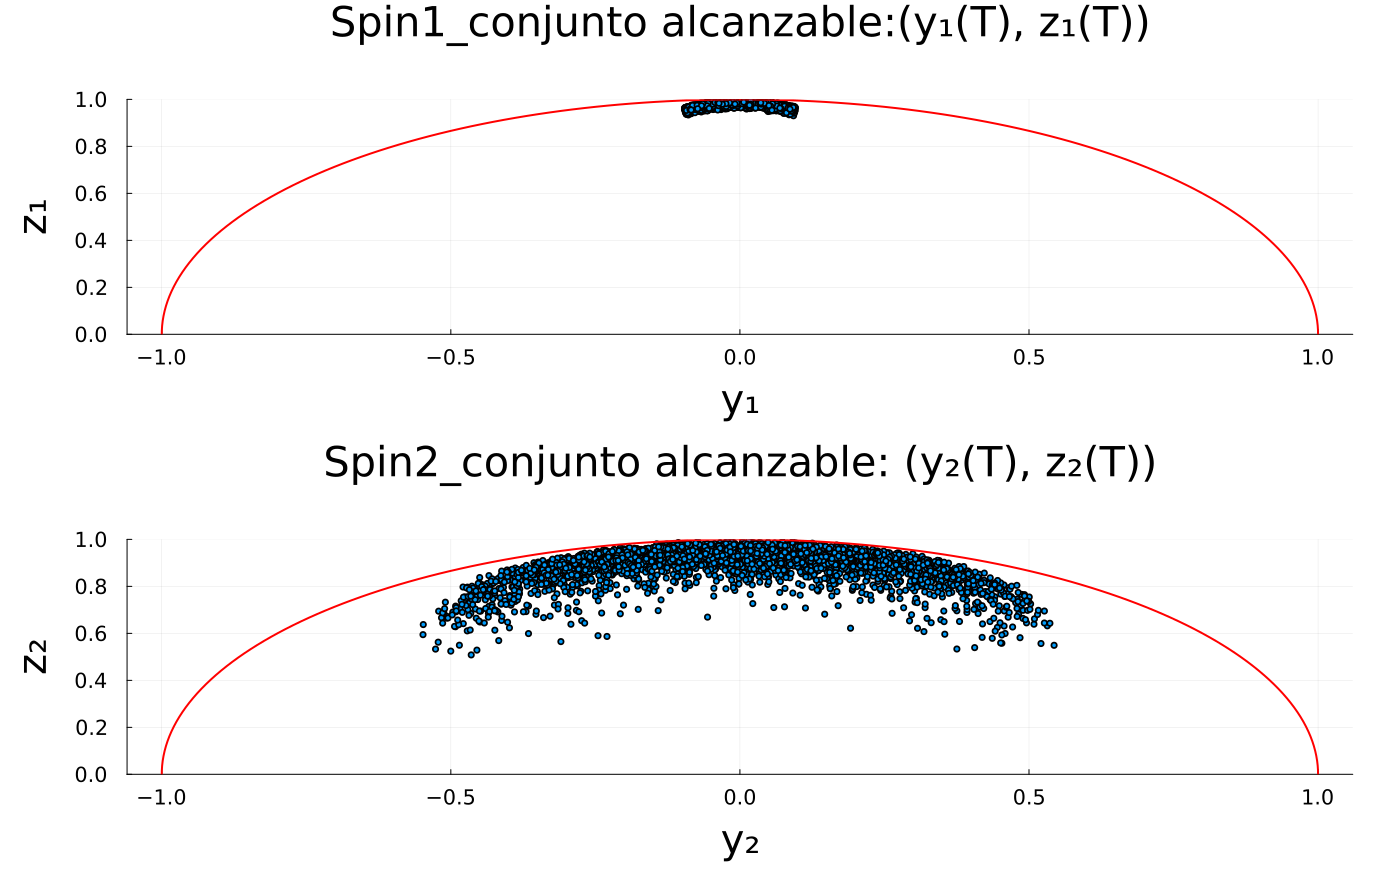

In [7]:
# ============================================================
# Parámetros
# ============================================================
Γ1, γ1 = 10.0, 1.0
Γ2, γ2 = 1.0, 0.5
x0 = [0.0, 1.0, 0.0, 1.0]
T = 1.564*3 # 4.0
Ncontrols = 3200 # 1200
Nsteps = 10 # 8

# ============================================================
# Dinámica del sistema (CORREGIDA)
# ============================================================
function spins!(dx, x, p, t)
    Γ1, γ1, Γ2, γ2, u = p

    ut = u(t)   # <---- u evaluado en t (esto evita el error)

    dx[1] = -Γ1 * x[1] - ut * x[2]
    dx[2] = γ1 * (1 - x[2]) + ut * x[1]
    dx[3] = -Γ2 * x[3] - ut * x[4]
    dx[4] = γ2 * (1 - x[4]) + ut * x[3]
end

# ============================================================
# Control por tramos
# ============================================================
function make_u(tvec, uvals)
    function ufun(t)
        for i in 1:length(tvec)-1
            if tvec[i] ≤ t < tvec[i+1]
                return uvals[i]
            end
        end
        return uvals[end]
    end
    return ufun
end

# ============================================================
# Barrido de controles
# ============================================================
ts = range(0, T, length = Nsteps + 1)
final_points = zeros(Float64, 4, Ncontrols)

Random.seed!(11)

for k in 1:Ncontrols

    uvals = rand(Nsteps) .* 2*1 .- 1*1        # valores en [-1,1] ## uvals = rand([-1.0, 1.0], Nsteps)
    u = make_u(ts, uvals)                 # función u(t)

    p = (Γ1, γ1, Γ2, γ2, u)
    prob = ODEProblem(spins!, x0, (0.0, T), p)
    sol = solve(prob)

    final_points[:, k] = sol(T)
end

println("Acc(x0,T) aproximado con éxito.")

# ============================================================
# Semicírculo superior (Bloch)
# ============================================================
θ = range(0, 2π, length=300)
yc = @. sin(θ)
zc = @. cos(θ)

# ============================================================
# Gráficos
# ============================================================
p1 = scatter(final_points[1,:], final_points[2,:],
             xlabel="y₁", ylabel="z₁",
             title="Spin1_conjunto alcanzable:(y₁(T), z₁(T))",
             markersize=3, legend=false,
             ylim=(0,1),
             titlefontsize=28,
             guidefontsize=27,
             tickfontsize=14)

plot!(p1, yc, zc, color=:red, lw=2, label="semicírculo")

p2 = scatter(final_points[3,:], final_points[4,:],
             xlabel="y₂", ylabel="z₂",
             title="Spin2_conjunto alcanzable: (y₂(T), z₂(T))",
             markersize=3, legend=false,
             ylim=(0,1),
             titlefontsize=28,
             guidefontsize=27,
             tickfontsize=14)

plot!(p2, yc, zc, color=:red, lw=2, label="semicírculo")

#plot(p1, p2, layout=(1,2), size=(850,400))
#plot(p1, p2, layout=(2,1), size=(1700,900))
#plot(p1, p2, layout=(2,1), size=(1400,1100), margin=10mm)
plot(p1, p2, layout=(2,1), size=(1400,880), margin=10mm, top_margin=15mm)
#plot(p1, p2, layout=(1,2), size=(1700,500))
#display(plot(p1, size=(500,250)))
#display(plot(p2, size=(500,250)))

`Experimento_1`

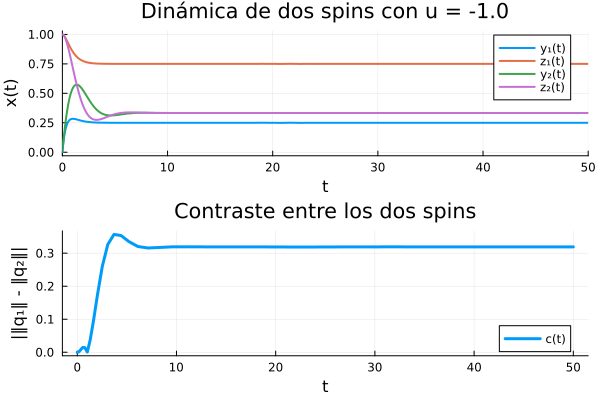

In [8]:
# Parámetros
Γ1, γ1 = 3.0, 1.0
Γ2, γ2 = 1.0, 0.5 

u = -1.0 # u constante con |u|<=1

# Sistema de EDO
function spins!(dx, x, p, t)
    Γ1, γ1, Γ2, γ2, u = p

    dx[1] = -Γ1 * x[1] - u * x[2]          # ẏ₁
    dx[2] = γ1 * (1 - x[2]) + u * x[1]     # ż₁
    dx[3] = -Γ2 * x[3] - u * x[4]          # ẏ₂
    dx[4] = γ2 * (1 - x[4]) + u * x[3]     # ż₂
end

# Condición inicial
x0 = [0.0, 1.0, 0.0, 1.0]

# Intervalo de tiempo
T = 50.0
tspan = (0.0, T)

# Paquete de parámetros
p = (Γ1, γ1, Γ2, γ2, u)

# Definir problema
prob = ODEProblem(spins!, x0, tspan, p)

# Resolver
sol = solve(prob)

# --------- Nuevo: contraste |‖q1‖ - ‖q2‖| ---------
q1 = sqrt.(sol[1,:].^2 .+ sol[2,:].^2)
q2 = sqrt.(sol[3,:].^2 .+ sol[4,:].^2)
contraste = abs.(q1 .- q2)

# --------- Gráfico principal ---------
p1 = plot(sol,
          xlabel = "t",
          ylabel = "x(t)",
          label = ["y₁(t)" "z₁(t)" "y₂(t)" "z₂(t)"],
          lw = 2,
          title = "Dinámica de dos spins con u = -1.0")

# --------- Gráfico del contraste ---------
p2 = plot(sol.t, contraste,
          lw = 3,
          xlabel = "t",
          ylabel = "|‖q₁‖ - ‖q₂‖|",
          label = "c(t)",
          title = "Contraste entre los dos spins")

plot(p1, p2, layout = (2,1))

`Experimento_2`

┌ Warning: could not parse Ipopt log file. SystemError("opening file \"C:\\\\Users\\\\CRISTI~1\\\\AppData\\\\Local\\\\Temp\\\\jl_LaFIp8fSzU\"", 13, nothing)
└ @ NLPModelsIpopt C:\Users\Cristian Reidel\.julia\packages\NLPModelsIpopt\OGzSv\src\NLPModelsIpopt.jl:297


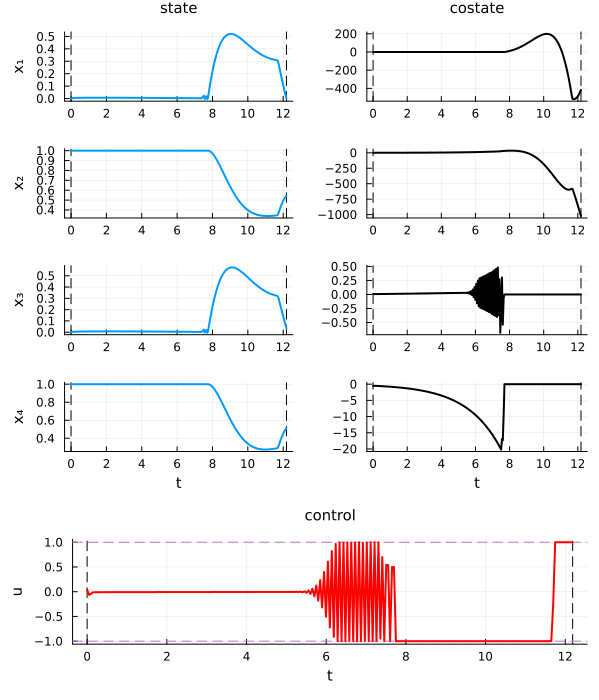

In [9]:
# Parámetros del modelo
λ = 5
T_min = 2.437
#
T = λ * T_min # tiempo final fijo con λ>=1
Γ1, γ1 = 1.2, 0.5
Γ2, γ2 = 1.0, 0.5 

# Definición del problema de control óptimo
ocp = @def begin
    t ∈ [0, T], time
    x ∈ R⁴, state   # x = [y1, z1, y2, z2]
    u ∈ R, control

    # Condiciones iniciales
    x(0) == [0.0, 1.0, 0.0, 1.0]
    
    # Condiciones finales para el spin 1 (saturación)
    x(T)[1] == 0.0
    x(T)[2] == 0.0

    # Dinámica del sistema (dos spins)
    ẋ(t) == [
        -Γ1 * x[1](t) - u(t) * x[2](t),                      # ẏ₁
         γ1 * (1 - x[2](t)) + u(t) * x[1](t),                # ż₁
        -Γ2 * x[3](t) - u(t) * x[4](t),                      # ẏ₂
         γ2 * (1 - x[4](t)) + u(t) * x[3](t)                 # ż₂
    ]

    # Restricción de control
    -1 ≤ u(t) ≤ 1
    # 
    x[1](t)^2 + x[2](t)^2 ≤ 1
    x[3](t)^2 + x[4](t)^2 ≤ 1

    # Función objetivo: maximizar (y_2² + z_2²)  ≡ minimizar -(y_2² + z_2²)
    # Obs: ∫( 1 * u(t)^2 ) - 0.5 * (x(T)[3]^2 + x(T)[4]^2) → min
    -1.0 * (x(T)[3]^2 + x(T)[4]^2) → min
end

sol = solve(ocp; display=false)
#sol = solve(ocp; grid_size=250, display=false)
#sol = solve(ocp)

#plot(sol) 
plot(sol, :state,:control,:costate;                 
     costate_style = (color=:black,), 
     control_style = (color=:red, linewidth=2),
     control_bounds_style = (linestyle = :dash,))       

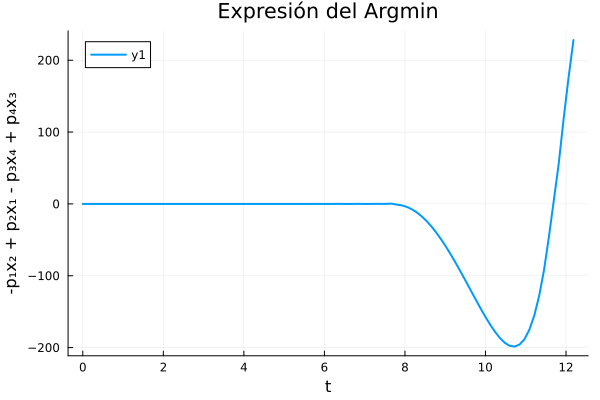

In [10]:
# --- Construir el tiempo ---
Time = range(0, λ * T_min, length=101)

# --- Extraer estados y coestados ---
x = [sol.state.value(t) for t in Time]   # Cada x[t] es un vector [x1,x2,x3,x4]
p = [sol.costate(t) for t in Time]       # Cada p[t] es un vector [p1,p2,p3,p4]

# --- Construir la señal  f(t) = -p1*x2 + p2*x1 - p3*x4 + p4*x3 ---
f = [
    -p[t][1] * x[t][2] +
     p[t][2] * x[t][1] -
     p[t][3] * x[t][4] +
     p[t][4] * x[t][3]
    for t in 1:length(Time)
]

# --- Graficar ---
plot(Time, f,
    xlabel = "t",
    ylabel = "-p₁x₂ + p₂x₁ - p₃x₄ + p₄x₃",
    title  = "Expresión del Argmin",
    lw = 2
)

In [11]:
#fieldnames(typeof(sol.costate))
sol.costate(0)

4-element Vector{Float64}:
 -0.009179327061984531
  0.5576217347943593
  0.009257812099352005
 -0.5115793558612599

In [12]:
sol.control.value(12)

1.0000000098649928

In [13]:
xT = sol.state.value(T)
println("y₁(T) = ", round(xT[1], digits=3))
println("z₁(T) = ", round(xT[2], digits=3))
println("Valor de la función objetivo = ", sol.objective)

y₁(T) = 0.0
z₁(T) = 0.546
Valor de la función objetivo = -0.2660921341140599


`Resolución del modelo usando Julia`

In [14]:
function Problema(λ,T_min,Γ1,γ1,Γ2,γ2)
    T = λ * T_min  # tiempo final

    # Definición del problema de control óptimo
    ocp = @def begin
        t ∈ [0, T], time
        x ∈ R⁴, state   # x = [y1, z1, y2, z2]
        u ∈ R, control

        # Condiciones iniciales
        x(0) == [0.0, 1.0, 0.0, 1.0]

        # Condiciones finales para el spin 1 (saturación)
        x(T)[1] == 0.0
        x(T)[2] == 0.0

        # Dinámica del sistema (dos spins)
        ẋ(t) == [
            -Γ1 * x[1](t) - u(t) * x[2](t),                      # ẏ₁
             γ1 * (1 - x[2](t)) + u(t) * x[1](t),                # ż₁
            -Γ2 * x[3](t) - u(t) * x[4](t),                      # ẏ₂
             γ2 * (1 - x[4](t)) + u(t) * x[3](t)                 # ż₂
        ]

        # Restricción de control
        -1 ≤ u(t) ≤ 1
        # 
        x[1](t)^2 + x[2](t)^2 ≤ 1
        x[3](t)^2 + x[4](t)^2 ≤ 1

        # Función objetivo
        -1.0 * (x(T)[3]^2 + x(T)[4]^2) → min
    end

    # Resolver el problema
    sol = solve(ocp; display=false)
    
    xT = sol.state.value(T)
    println("y₁(T) = ", round(xT[1], digits=3))
    println("z₁(T) = ", round(xT[2], digits=3))
    println("Valor de la función objetivo = ", sol.objective,"\n")
    
    println("""
    ================ Parámetros del gráfico ================
    λ      = $λ
    T_min  = $T_min
    T      = $(λ * T_min)
    Γ1     = $Γ1
    γ1     = $γ1
    Γ2     = $Γ2
    γ2     = $γ2
    ========================================================
    """)
    
    #p1 = plot(sol, :control;                  
    #     costate_style = (color=:black,), 
    #     control_style = (color=:red, linewidth=2),
    #     control_bounds_style = (linestyle = :dash,))
    
    # --- Construir el tiempo ---
    Time = range(0, λ * T_min, length=501)

    # --- Extraer estados y coestados ---
    x_control = [sol.control.value(t) for t in Time]
    #
    x = [sol.state.value(t) for t in Time]   # Cada x[t] es un vector [x1,x2,x3,x4]
    p = [sol.costate(t) for t in Time]       # Cada p[t] es un vector [p1,p2,p3,p4]

    # --- Construir la señal  f(t) = -p1*x2 + p2*x1 - p3*x4 + p4*x3 ---
    f = [
        -p[t][1] * x[t][2] +
         p[t][2] * x[t][1] -
         p[t][3] * x[t][4] +
         p[t][4] * x[t][3]
        for t in 1:length(Time)
    ]
    
    # --- Graficar ---
    p1 = plot(Time, x_control,
        xlabel = "t",
        ylabel = "u*(t)",         # símbolo en cursiva
        title  = "Control",
        lw = 2,
        color = :red,
        legend = false,
        titlefontsize = 28,
        guidefontsize = 27,
        tickfontsize = 14
        )

    # --- Graficar phi(t) ---
    pϕ = plot(Time, -f,
        xlabel = "t",
        ylabel = "ϕ(t)",         # símbolo en cursiva
        title  = "Función de Conmutación",
        lw = 2,
        legend = false,
        titlefontsize = 28,
        guidefontsize = 27,
        tickfontsize = 14
        )
    
    t=0.0
    for i in 1:length(Time)
        if Time[i] > 10 && f[i] >= 0
            t = Time[i]
            break  # Opcional: si solo quieres el primer valor que cumple la condición
        end
    end
        
    vline!(pϕ, [8], color=:green, linestyle=:dot, lw=2)
    vline!(pϕ, [t], color=:green, linestyle=:dot, lw=2)
    plot(p1, pϕ, layout=(2,1), size=(1400,1200), margin=10mm, top_margin=15mm)
end

Problema (generic function with 1 method)

┌ Warning: could not parse Ipopt log file. SystemError("opening file \"C:\\\\Users\\\\CRISTI~1\\\\AppData\\\\Local\\\\Temp\\\\jl_jevC5gdgPM\"", 13, nothing)
└ @ NLPModelsIpopt C:\Users\Cristian Reidel\.julia\packages\NLPModelsIpopt\OGzSv\src\NLPModelsIpopt.jl:297


y₁(T) = 0.0
z₁(T) = 0.546
Valor de la función objetivo = -0.2660921341140599

================ Parámetros del gráfico ================
λ      = 5
T_min  = 2.437
T      = 12.184999999999999
Γ1     = 1.2
γ1     = 0.5
Γ2     = 1
γ2     = 0.5



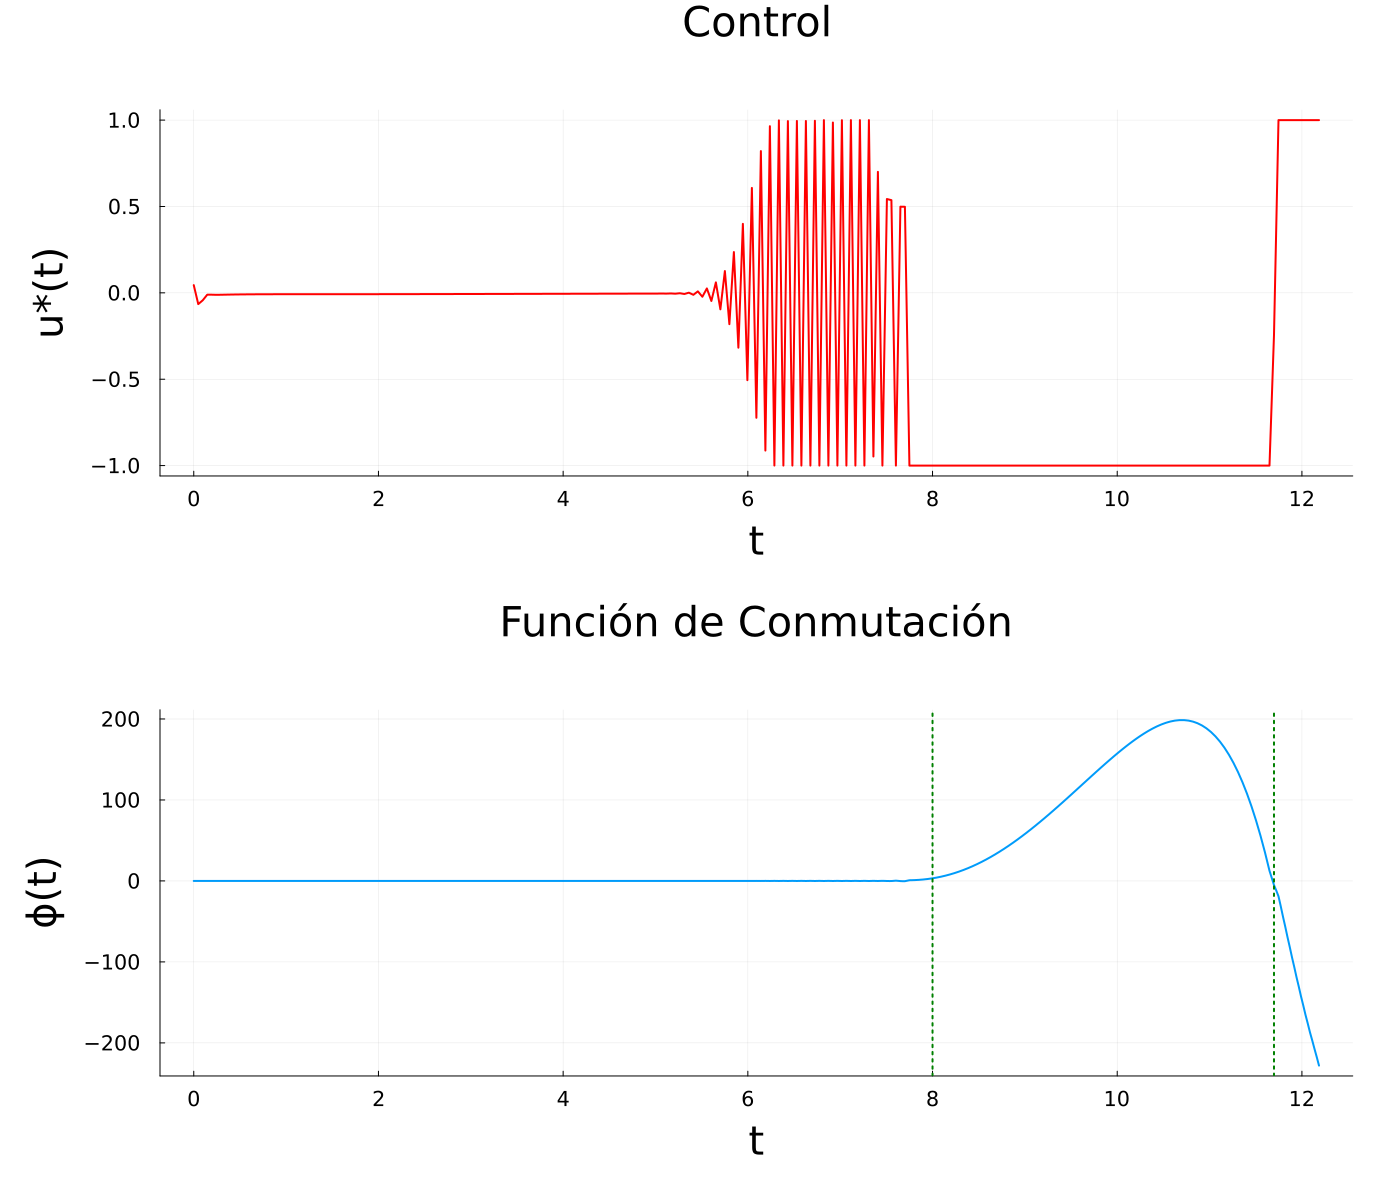

In [15]:
Problema(5,2.437,1.2,0.5,1,0.5)

In [16]:
function Problema(λ,T_min,Γ1,γ1,Γ2,γ2)
    T = λ * T_min  # tiempo final

    # Definición del problema de control óptimo
    ocp = @def begin
        t ∈ [0, T], time
        x ∈ R⁴, state   # x = [y1, z1, y2, z2]
        u ∈ R, control

        # Condiciones iniciales
        x(0) == [0.0, 1.0, 0.0, 1.0]

        # Condiciones finales para el spin 1 (saturación)
        x(T)[1] == 0.0
        x(T)[2] == 0.0

        # Dinámica del sistema (dos spins)
        ẋ(t) == [
            -Γ1 * x[1](t) - u(t) * x[2](t),                      # ẏ₁
             γ1 * (1 - x[2](t)) + u(t) * x[1](t),                # ż₁
            -Γ2 * x[3](t) - u(t) * x[4](t),                      # ẏ₂
             γ2 * (1 - x[4](t)) + u(t) * x[3](t)                 # ż₂
        ]

        # Restricción de control
        -1 ≤ u(t) ≤ 1
        # 
        x[1](t)^2 + x[2](t)^2 ≤ 1
        x[3](t)^2 + x[4](t)^2 ≤ 1

        # Función objetivo
        -1.0 * (x(T)[3]^2 + x(T)[4]^2) → min
    end

    # Resolver el problema
    sol = solve(ocp; display=false)
    
    xT = sol.state.value(T)
    println("y₁(T) = ", round(xT[1], digits=3))
    println("z₁(T) = ", round(xT[2], digits=3))
    println("Valor de la función objetivo = ", sol.objective,"\n")
    
    println("""
    ================ Parámetros del gráfico ================
    λ      = $λ
    T_min  = $T_min
    T      = $(λ * T_min)
    Γ1     = $Γ1
    γ1     = $γ1
    Γ2     = $Γ2
    γ2     = $γ2
    ========================================================
    """)
    
    display(plot(sol, :control;                  
         costate_style = (color=:black,), 
         control_style = (color=:red, linewidth=2),
         control_bounds_style = (linestyle = :dash,)))  
    
    # --- Construir el tiempo ---
    Time = range(0, λ * T_min, length=501)

    # --- Extraer estados y coestados ---
    x = [sol.state.value(t) for t in Time]   # Cada x[t] es un vector [x1,x2,x3,x4]
    p = [sol.costate(t) for t in Time]       # Cada p[t] es un vector [p1,p2,p3,p4]

    # --- Construir la señal  f(t) = -p1*x2 + p2*x1 - p3*x4 + p4*x3 ---
    f = [
        -p[t][1] * x[t][2] +
         p[t][2] * x[t][1] -
         p[t][3] * x[t][4] +
         p[t][4] * x[t][3]
        for t in 1:length(Time)
    ]

    # --- Graficar ---
    display(plot(Time, -f,
        xlabel = "t",
        ylabel = "-p₁z₁ + p₂y₁ - p₃z₂ + p₄y₂",
        title  = "Expresión del Argmin",
        lw = 2,
        legend = false
    ))
end

Problema (generic function with 1 method)

In [17]:
# Parámetros del modelo
#λ = [1, 1.1, 1.5, 1.8, 2.0, 3.0]
λ = [1, 1.5, 2.0, 3.0, 5.0, 10.0]
T_min = [2.437, 1.975, 1.753, 1.564]
#
Γ1 = [1.2, 3.0, 5.0, 10.0]
γ1 = [0.5, 1.0, 2.0, 1.0]
Γ2 = [1.0, 1.0, 2.0, 1.0]
γ2 = [0.5, 0.5, 0.5, 0.5];

`Testeo_1: λ[2, 3, 5] Libre`

┌ Warning: could not parse Ipopt log file. SystemError("opening file \"C:\\\\Users\\\\CRISTI~1\\\\AppData\\\\Local\\\\Temp\\\\jl_nM9gXs5uL2\"", 13, nothing)
└ @ NLPModelsIpopt C:\Users\Cristian Reidel\.julia\packages\NLPModelsIpopt\OGzSv\src\NLPModelsIpopt.jl:297


y₁(T) = 0.0
z₁(T) = 0.562
Valor de la función objetivo = -0.28433972382992745

================ Parámetros del gráfico ================
λ      = 1.5
T_min  = 2.437
T      = 3.6555
Γ1     = 1.2
γ1     = 0.5
Γ2     = 1.0
γ2     = 0.5



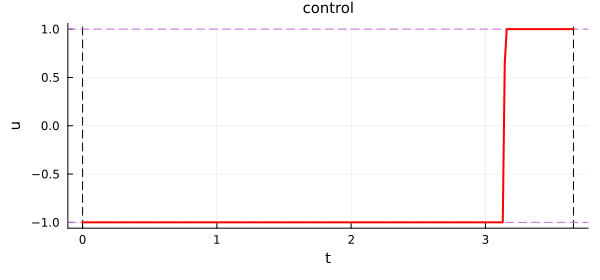

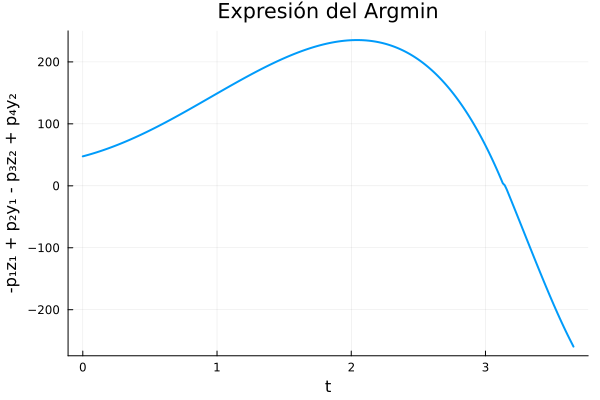

In [18]:
Problema(λ[2],T_min[1],Γ1[1],γ1[1],Γ2[1],γ2[1])

`Testeo_2: λ[4, 5, 6] Libre`

┌ Warning: could not parse Ipopt log file. SystemError("opening file \"C:\\\\Users\\\\CRISTI~1\\\\AppData\\\\Local\\\\Temp\\\\jl_T87WrGTkpw\"", 13, nothing)
└ @ NLPModelsIpopt C:\Users\Cristian Reidel\.julia\packages\NLPModelsIpopt\OGzSv\src\NLPModelsIpopt.jl:297


y₁(T) = 0.0
z₁(T) = 0.822
Valor de la función objetivo = -0.2455013815604027

================ Parámetros del gráfico ================
λ      = 10.0
T_min  = 1.975
T      = 19.75
Γ1     = 3.0
γ1     = 1.0
Γ2     = 1.0
γ2     = 0.5



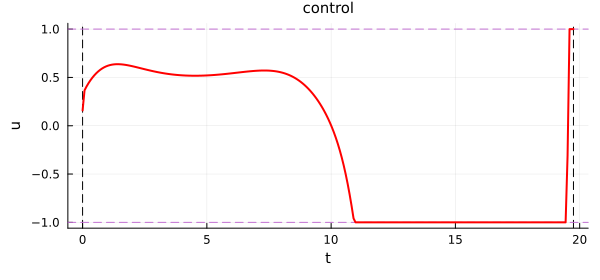

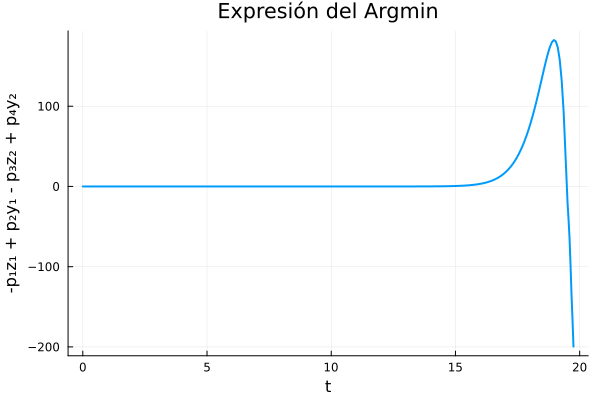

In [19]:
Problema(λ[6],T_min[2],Γ1[2],γ1[2],Γ2[2],γ2[2])

`Testeo_3: λ[3, 4, 5, 6] Libre`

y₁(T) = 0.0
z₁(T) = 0.941
Valor de la función objetivo = -0.32767326068606395

================ Parámetros del gráfico ================
λ      = 10.0
T_min  = 1.753
T      = 17.529999999999998
Γ1     = 5.0
γ1     = 2.0
Γ2     = 2.0
γ2     = 0.5



┌ Warning: could not parse Ipopt log file. SystemError("opening file \"C:\\\\Users\\\\CRISTI~1\\\\AppData\\\\Local\\\\Temp\\\\jl_V07w1ELIRM\"", 13, nothing)
└ @ NLPModelsIpopt C:\Users\Cristian Reidel\.julia\packages\NLPModelsIpopt\OGzSv\src\NLPModelsIpopt.jl:297


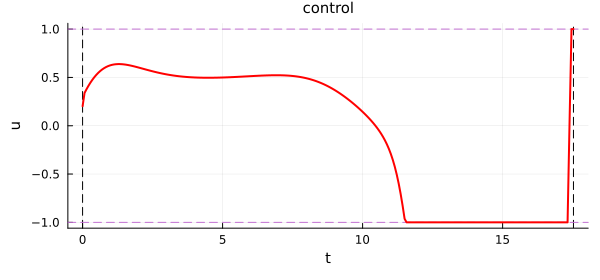

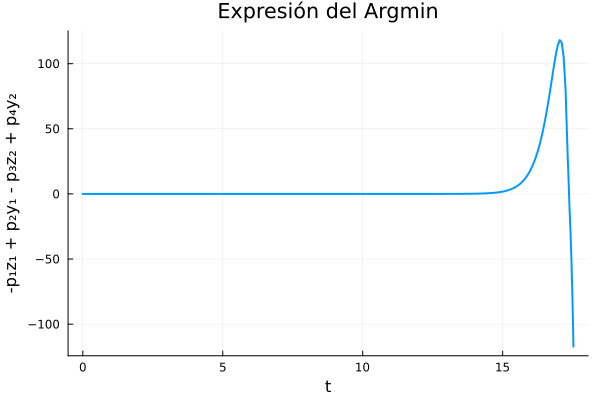

In [20]:
Problema(λ[6],T_min[3],Γ1[3],γ1[3],Γ2[3],γ2[3])

`Testeo_3: λ[3, 5, 6] Libre`

y₁(T) = 0.0
z₁(T) = 0.919
Valor de la función objetivo = -0.22642082269393507

================ Parámetros del gráfico ================
λ      = 10.0
T_min  = 1.564
T      = 15.64
Γ1     = 10.0
γ1     = 1.0
Γ2     = 1.0
γ2     = 0.5



┌ Warning: could not parse Ipopt log file. SystemError("opening file \"C:\\\\Users\\\\CRISTI~1\\\\AppData\\\\Local\\\\Temp\\\\jl_H0Dg9o5o3k\"", 13, nothing)
└ @ NLPModelsIpopt C:\Users\Cristian Reidel\.julia\packages\NLPModelsIpopt\OGzSv\src\NLPModelsIpopt.jl:297


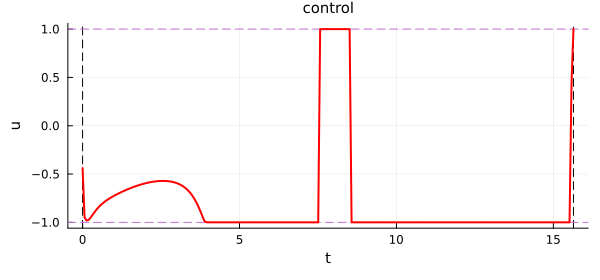

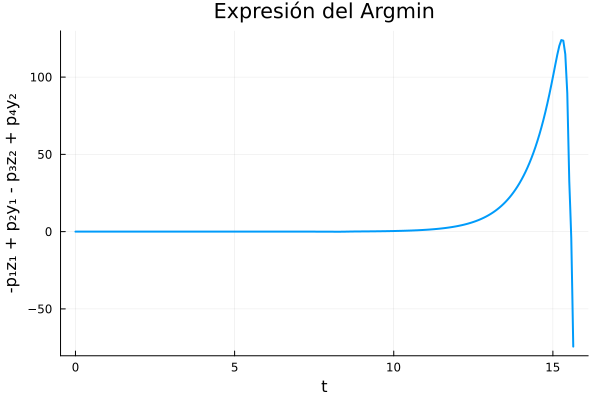

In [21]:
Problema(λ[6],T_min[4],Γ1[4],γ1[4],Γ2[4],γ2[4])